In [1]:
import mdtraj as md
import MDAnalysis as mda
import numpy as np

from tqdm import tqdm
from pathlib import Path
import os
from natsort import natsorted
import pandas as pd
from addict import Dict as Adict

import pyemma as pm
import deeptime as dt
import deeptime.markov.msm as msm
import deeptime.markov.hmm as hmm

from deeptime.plots import plot_implied_timescales, plot_energy2d, plot_contour2d_from_xyz, plot_flux
from deeptime.markov.sample import *
from deeptime.markov import TransitionCountEstimator
from deeptime.util import energy2d
from deeptime.markov.tools import *

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm 
import seaborn as sns
import networkx as nx

from funcs_build_msm import _tica, _kmeans, get_data 
from funcs_validate_msm import *
from funcs_sample import *
from funcs_plotting import *

/home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
features = ['dbdist', 'dbdihed', 'aloop', 'achelix']
abl_ftraj_dir = Path(f'data_abl/ftrajs')
egfr_ftraj_dir = Path(f'data_egfr/ftrajs')

In [3]:
abl_ftrajs, _ = get_data(trajlen_cutoff=1000, features=features, ftraj_dir=abl_ftraj_dir)
egfr_ftrajs, _ = get_data(trajlen_cutoff=1000, features=features, ftraj_dir=egfr_ftraj_dir)

Loading feature:  dbdist


  0%|          | 0/749 [00:00<?, ?it/s]

100%|██████████| 749/749 [00:00<00:00, 8251.41it/s]


Loading feature:  dbdihed


100%|██████████| 749/749 [00:00<00:00, 974.36it/s] 


Loading feature:  aloop


100%|██████████| 749/749 [01:03<00:00, 11.87it/s]


Loading feature:  achelix


100%|██████████| 749/749 [00:08<00:00, 86.23it/s] 


Loaded number of ftrajs: 416
Loading feature:  dbdist


100%|██████████| 3472/3472 [00:28<00:00, 121.85it/s]


Loading feature:  dbdihed


100%|██████████| 3472/3472 [01:25<00:00, 40.84it/s]


Loading feature:  aloop


100%|██████████| 3472/3472 [03:46<00:00, 15.33it/s]


Loading feature:  achelix


100%|██████████| 3472/3472 [00:34<00:00, 101.28it/s]

Loaded number of ftrajs: 1988


In [4]:
abl_ftrajs_stride = [ftraj[::1000] for ftraj in abl_ftrajs]
egfr_ftrajs_stride = [ftraj[::1000] for ftraj in egfr_ftrajs]

In [5]:
hp_dict = Adict({'hp_id': 2,
                'trajlen__cutoff': 1000,
                'n__boot': 20,
                'seed': 49587,
                'tica__lag': 10,
                'tica__stride': 1,
                'tica__dim': 20,
                'cluster__k': 1000,
                'cluster__stride': 1000,
                'cluster__maxiter': 1000,
                'markov__lag': 100})

In [6]:
ttrajs, tica_mod = _tica(hp_dict, abl_ftrajs_stride+egfr_ftrajs_stride) 

/home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
100%|██████████| 2404/2404 [00:00<00:00, 12394.46it/s]                        


In [7]:
abl_ttrajs = tica_mod.transform(abl_ftrajs)
egfr_ttrajs = tica_mod.transform(egfr_ftrajs)

In [9]:
abl_dtrajs, abl_kmeans_mod = _kmeans(hp_dict, abl_ttrajs, seed=42)
egfr_dtrajs, egfr_kmeans_mod = _kmeans(hp_dict, egfr_ttrajs, seed=42)

/home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
100%|██████████| 1000/1000 [00:00<00:00, 1949.69it/s]
/home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/numpy/core/numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
100%|██████████| 416/416 [00:07<00:00, 54.09it/s]                                    
/home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(f

In [24]:
from MSManalysis import *

In [25]:
MA = MSMAnalysis('egfr')

In [32]:
MA.set_features(features)

In [20]:
traj_all = np.concatenate(abl_ttrajs + egfr_ttrajs)

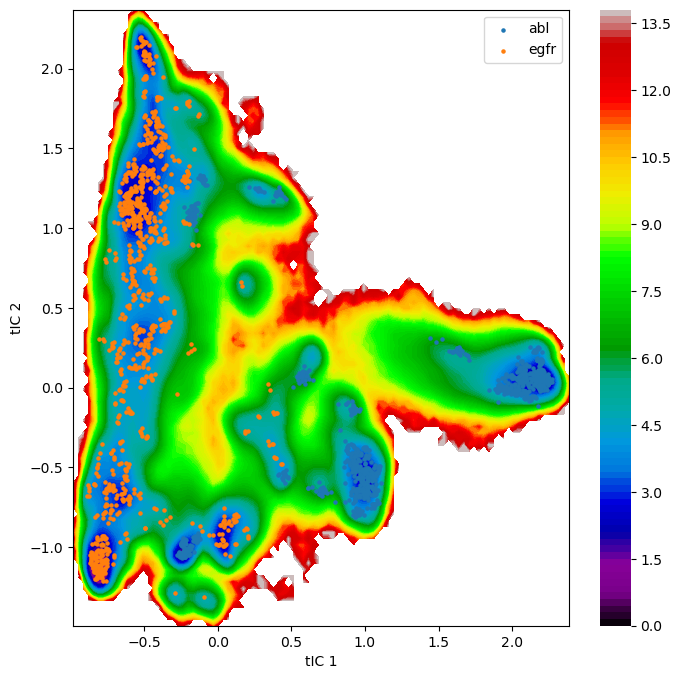

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
fes_cmap='nipy_spectral'
ax, contour, cbar = plot_energy2d(energy2d(traj_all[:, 0], traj_all[:, 1]), ax=ax, contourf_kws=dict(cmap=fes_cmap))

ax.scatter(abl_kmeans_mod.clustercenters[:,0], abl_kmeans_mod.clustercenters[:,1], s=5, label='abl')
ax.scatter(egfr_kmeans_mod.clustercenters[:,0], egfr_kmeans_mod.clustercenters[:,1], s=5, label='egfr')

ax.set_xlabel('tIC 1')
ax.set_ylabel('tIC 2')
ax.legend()
plt.show()